In [892]:
from odak import np
import matplotlib.pyplot as plt
from odak.wave import *
from Openholo.Openholo_python.ophpy.Depthmap import *
from odak.learn.wave import propagate_beam as propagate_beam_torch
import matplotlib.image as mpimg
from PIL import Image
from loss_function import PSNR, get_single_psnr
from generator import *
from tqdm import tqdm
from __functions2 import *
import math
from phase_optimization import *

import tensorflow as tf
from keras import layers

In [893]:
wavelength_r = 633e-9
wavelength_g = 532e-9
wavelength_b = 473e-9

k_r = 2*np.pi/wavelength_r
k_g = 2*np.pi/wavelength_g
k_b = 2*np.pi/wavelength_b

pixel_size = 8.5e-6
shape = (756,1344,1)

depth1 = 0.5
depth2 = 0.6
depth3 = 1
depth4 = 1.5
depth5 = 2

In [894]:
# 샘플링 팩터 괄호 없이 더하면 위상 홀로그램의 프린지 패턴이 없어지는 반면 numerical recon은 깔끔함.
# 샘플링 팩터를 괄호 포함해서 더하면 위상 홀로그램의 프린지 패턴이 있는 반면에 numerical recon은 깔끔하지 못함. 
# 그냥 BL-ASM도 프린지 패턴 있음. 대신 numerical recon이 깔끔하게 나오지 않음. 

# 프린지 패턴이 존재하고 numerical recon도 깔끔하게 하려면 어떻게 해야할까.. ㅠ 곱해봐야하나. 
# 샘플링 팩터를 괄호 포함해서 곱하면 위상 홀로그램의 프린지 패턴이 있고 numerical recon도 깔끔함. 근데 완전 똑같이 나옴..ㅋㅋ => 딥러닝 돌려봐야할 듯?

def band_limited_angular_spectrum1(field, k, distance, dx, wavelength, sampling_factor):

    nv, nu = field.shape[0],field.shape[1] # (756,1344)
    x = np.linspace(-(nu*sampling_factor)/2*dx, (nu*sampling_factor)/2*dx, nu) # x = (1344,)  => 여기서의 샘플링 팩터의 개념을 정확히 파악해야함. 
    y = np.linspace(-(nv*sampling_factor)/2*dx, (nv*sampling_factor)/2*dx, nv) # y = (756,)
    X, Y = np.meshgrid(x, y) # X, Y 모두 (756, 1344)
    Z = X**2+Y**2 # 원형 모양 
    h = 1./(1j*wavelength*distance)*np.exp(1j*k*(distance+Z/2/distance))
    h = np.fft.fft2(np.fft.fftshift(h))*dx**2 # 이미지 영역이 주파수 영역으로
    flimx = np.ceil(1/(((2*distance*(1./(nu)))**2+1)**0.5*wavelength))  # 전달함수가 엘리어싱 오류를 일으키지 않는 주파수의 범위를 나타낸 것. 
    flimy = np.ceil(1/(((2*distance*(1./(nv)))**2+1)**0.5*wavelength))  
    mask = np.zeros((nu, nv)) 
    mask = tf.cast(mask, dtype=tf.complex64) 
    mask = (np.abs(X) < flimx) & (np.abs(Y) < flimy) # 여기서 band limit하는 듯. X와 Y는 u를 뜻함. 
    mask = set_amplitude(h, mask) # phase와 amplitude로 변환 후 새로운 field인 mask로 계산.(cos,sin,1j 사용)
    field = tf.cast(field,dtype=tf.complex64)
    # field = field[:,:,:,0]
    U1 = tf.signal.fft2d(tf.signal.fftshift(field)) # 이미지 영역이 주파수 영역으로
    U2 = mask*U1
    result = tf.signal.ifftshift(tf.signal.ifft2d(U2)) # 다시 이미지 영역으로
    # recon = tf.math.abs(result)
    # recon = tf.cast(recon,tf.float32)

    return result


def band_limited_angular_spectrum2(field, k, distance, dx, wavelength, sampling_factor):

    nv, nu = field.shape[0],field.shape[1] # (756,1344)
    x = np.linspace(-(nu*sampling_factor)/2*dx, (nu*sampling_factor)/2*dx, nu) # x = (1344,)  => 여기서의 샘플링 팩터의 개념을 정확히 파악해야함. 
    y = np.linspace(-(nv*sampling_factor)/2*dx, (nv*sampling_factor)/2*dx, nv) # y = (756,)
    X, Y = np.meshgrid(x, y) # X, Y 모두 (756, 1344)
    Z = X**2+Y**2 # 원형 모양 
    h = 1./(1j*wavelength*distance)*np.exp(1j*k*(distance+Z/2/distance))
    h = np.fft.fft2(np.fft.fftshift(h))*dx**2 # 이미지 영역이 주파수 영역으로
    flimx = np.ceil(1/(((2*distance*(1./(nu)))**2+1)**0.5*wavelength))  # 전달함수가 엘리어싱 오류를 일으키지 않는 주파수의 범위를 나타낸 것. 
    flimy = np.ceil(1/(((2*distance*(1./(nv)))**2+1)**0.5*wavelength))  
    mask = np.zeros((nu, nv)) 
    mask = tf.cast(mask, dtype=tf.complex64) 
    mask = (np.abs(X) < flimx) & (np.abs(Y) < flimy) # 여기서 band limit하는 듯. X와 Y는 u를 뜻함. 
    mask = set_amplitude(h, mask) # phase와 amplitude로 변환 후 새로운 field인 mask로 계산.(cos,sin,1j 사용)
    field = tf.cast(field,dtype=tf.complex64)
    # field = field[:,:,:,0]
    U1 = tf.signal.fft2d(tf.signal.fftshift(field)) # 이미지 영역이 주파수 영역으로
    U2 = mask*U1
    result = tf.signal.ifftshift(tf.signal.ifft2d(U2)) # 다시 이미지 영역으로
    # recon = tf.math.abs(result)
    recon = tf.math.abs(result)/tf.reduce_max(tf.math.abs(result))
    # recon = tf.cast(recon,tf.float32)

    return recon

def band_limited_angular_spectrum3(field, k, distance, dx, wavelength,sampling_factor):

    nv, nu = field.shape[0],field.shape[1] # (756,1344)
    x = np.linspace(-nu/2*dx, nu/2*dx, nu) # x = (1344,)  => 여기서의 샘플링 팩터의 개념을 정확히 파악해야함. 
    y = np.linspace(-nv/2*dx, nv/2*dx, nv) # y = (756,)
    X, Y = np.meshgrid(x, y) # X, Y 모두 (756, 1344)
    Z = X**2+Y**2 # 원형 모양 
    h = 1./(1j*wavelength*distance)*np.exp(1j*k*(distance+Z/2/distance))
    h = np.fft.fft2(np.fft.fftshift(h))*dx**2 # 이미지 영역이 주파수 영역으로
    flimx = np.ceil(1/(((2*distance*(1./(nu*sampling_factor)))**2+1)**0.5*wavelength))  # 전달함수가 엘리어싱 오류를 일으키지 않는 주파수의 범위를 나타낸 것. 
    flimy = np.ceil(1/(((2*distance*(1./(nv*sampling_factor)))**2+1)**0.5*wavelength))  
    mask = np.zeros((nu, nv)) 
    mask = tf.cast(mask, dtype=tf.complex64) 
    mask = (np.abs(X) < flimx) & (np.abs(Y) < flimy) # 여기서 band limit하는 듯. X와 Y는 u를 뜻함. 
    mask = set_amplitude(h, mask) # phase와 amplitude로 변환 후 새로운 field인 mask로 계산.(cos,sin,1j 사용)
    field = tf.cast(field,dtype=tf.complex64)
    # field = field[:,:,:,0]
    U1 = tf.signal.fft2d(tf.signal.fftshift(field)) # 이미지 영역이 주파수 영역으로
    U2 = mask*U1
    result = tf.signal.ifftshift(tf.signal.ifft2d(U2)) # 다시 이미지 영역으로
    # recon = tf.math.abs(result)
    # recon = tf.cast(recon,tf.float32)

    return result

def band_limited_angular_spectrum4(field, k, distance, dx, wavelength,sampling_factor):

    nv, nu = field.shape[0],field.shape[1] # (756,1344)
    x = np.linspace(-nu/2*dx, nu/2*dx, nu) # x = (1344,)  => 여기서의 샘플링 팩터의 개념을 정확히 파악해야함. 
    y = np.linspace(-nv/2*dx, nv/2*dx, nv) # y = (756,)
    X, Y = np.meshgrid(x, y) # X, Y 모두 (756, 1344)
    Z = X**2+Y**2 # 원형 모양 
    h = 1./(1j*wavelength*distance)*np.exp(1j*k*(distance+Z/2/distance))
    h = np.fft.fft2(np.fft.fftshift(h))*dx**2 # 이미지 영역이 주파수 영역으로
    flimx = np.ceil(1/(((2*distance*(1./(nu*sampling_factor)))**2+1)**0.5*wavelength))  # 전달함수가 엘리어싱 오류를 일으키지 않는 주파수의 범위를 나타낸 것. 
    flimy = np.ceil(1/(((2*distance*(1./(nv*sampling_factor)))**2+1)**0.5*wavelength))  
    mask = np.zeros((nu, nv)) 
    mask = tf.cast(mask, dtype=tf.complex64) 
    mask = (np.abs(X) < flimx) & (np.abs(Y) < flimy) # 여기서 band limit하는 듯. X와 Y는 u를 뜻함. 
    mask = set_amplitude(h, mask) # phase와 amplitude로 변환 후 새로운 field인 mask로 계산.(cos,sin,1j 사용)
    field = tf.cast(field,dtype=tf.complex64)
    # field = field[:,:,:,0]
    U1 = tf.signal.fft2d(tf.signal.fftshift(field)) # 이미지 영역이 주파수 영역으로
    U2 = mask*U1
    result = tf.signal.ifftshift(tf.signal.ifft2d(U2)) # 다시 이미지 영역으로
    # recon = tf.math.abs(result)
    recon = tf.math.abs(result)/tf.reduce_max(tf.math.abs(result))
    # recon = tf.cast(recon,tf.float32)

    return recon


def band_limited_angular_spectrum5(field, k, distance, dx, wavelength):

    nv, nu = field.shape[0],field.shape[1] # (756,1344)
    x = np.linspace(-nu/2*dx, nu/2*dx, nu) # x = (1344,)  => 여기서의 샘플링 팩터의 개념을 정확히 파악해야함. 
    y = np.linspace(-nv/2*dx, nv/2*dx, nv) # y = (756,)
    X, Y = np.meshgrid(x, y) # X, Y 모두 (756, 1344)
    Z = X**2+Y**2 # 원형 모양 
    h = 1./(1j*wavelength*distance)*np.exp(1j*k*(distance+Z/2/distance))
    h = np.fft.fft2(np.fft.fftshift(h))*dx**2 # 이미지 영역이 주파수 영역으로
    flimx = np.ceil(1/(((2*distance*(1./(nu)))**2+1)**0.5*wavelength))  # 전달함수가 엘리어싱 오류를 일으키지 않는 주파수의 범위를 나타낸 것. 
    flimy = np.ceil(1/(((2*distance*(1./(nv)))**2+1)**0.5*wavelength))  
    mask = np.zeros((nu, nv)) 
    mask = tf.cast(mask, dtype=tf.complex64) 
    mask = (np.abs(X) < flimx) & (np.abs(Y) < flimy) # 여기서 band limit하는 듯. X와 Y는 u를 뜻함. 
    mask = set_amplitude(h, mask) # phase와 amplitude로 변환 후 새로운 field인 mask로 계산.(cos,sin,1j 사용)
    field = tf.cast(field,dtype=tf.complex64)
    # field = field[:,:,:,0]
    U1 = tf.signal.fft2d(tf.signal.fftshift(field)) # 이미지 영역이 주파수 영역으로
    U2 = mask*U1
    result = tf.signal.ifftshift(tf.signal.ifft2d(U2)) # 다시 이미지 영역으로
    # recon = tf.math.abs(result)
    # recon = tf.cast(recon,tf.float32)

    return result

def band_limited_angular_spectrum6(field, k, distance, dx, wavelength):

    nv, nu = field.shape[0],field.shape[1] # (756,1344)
    x = np.linspace(-nu/2*dx, nu/2*dx, nu) # x = (1344,)  => 여기서의 샘플링 팩터의 개념을 정확히 파악해야함. 
    y = np.linspace(-nv/2*dx, nv/2*dx, nv) # y = (756,)
    X, Y = np.meshgrid(x, y) # X, Y 모두 (756, 1344)
    Z = X**2+Y**2 # 원형 모양 
    h = 1./(1j*wavelength*distance)*np.exp(1j*k*(distance+Z/2/distance))
    h = np.fft.fft2(np.fft.fftshift(h))*dx**2 # 이미지 영역이 주파수 영역으로
    flimx = np.ceil(1/(((2*distance*(1./(nu)))**2+1)**0.5*wavelength))  # 전달함수가 엘리어싱 오류를 일으키지 않는 주파수의 범위를 나타낸 것. 
    flimy = np.ceil(1/(((2*distance*(1./(nv)))**2+1)**0.5*wavelength))  
    mask = np.zeros((nu, nv)) 
    mask = tf.cast(mask, dtype=tf.complex64) 
    mask = (np.abs(X) < flimx) & (np.abs(Y) < flimy) # 여기서 band limit하는 듯. X와 Y는 u를 뜻함. 
    mask = set_amplitude(h, mask) # phase와 amplitude로 변환 후 새로운 field인 mask로 계산.(cos,sin,1j 사용)
    field = tf.cast(field,dtype=tf.complex64)
    # field = field[:,:,:,0]
    U1 = tf.signal.fft2d(tf.signal.fftshift(field)) # 이미지 영역이 주파수 영역으로
    U2 = mask*U1
    result = tf.signal.ifftshift(tf.signal.ifft2d(U2)) # 다시 이미지 영역으로
    # recon = tf.math.abs(result)
    recon = tf.math.abs(result)/tf.reduce_max(tf.math.abs(result))
    # recon = tf.cast(recon,tf.float32)

    return recon


In [895]:
def recon_loss(y_true, y_pred):
    y_true = y_true[:,:,:,0] # angular spectrum 때만
    y_pred = band_limited_angular_spectrum(y_pred, k_r, depth2, pixel_size, wavelength_r)
    err = y_true - y_pred
    loss = tf.math.reduce_mean(tf.math.square(err)) 
    
    return loss

In [896]:
# 모델을 불러올 때 custom한 손실함수도 같이 불러온다. 그 코드에서 쓴 함수 이름으로 key도 설정됨
model = tf.keras.models.load_model('./image_Data/models/U2_11_2d_img_e100_b8_lr4d_f06_band_angular_1_final.h5',custom_objects={'recon_loss': recon_loss}) 

In [897]:
# 2d img를 입력과 출력으로. 

# train_img = np.asarray(Image.open('./image_data/Alpha/Blender_test/object/Ball_article_amp_f05~06.png'))
# test_img = np.asarray(Image.open('./image_data/Alpha/Blender_test/object/Ball_article_amp_f05~06.png'))
# train_img = np.asarray(Image.open('./image_data/Alpha/Blender_test/object/CBNU_article_amp_f05~06_white.png'))
# test_img = np.asarray(Image.open('./image_data/Alpha/Blender_test/object/CBNU_article_amp_f05~06_white.png'))
train_img = np.asarray(Image.open('./image_data/Alpha/Blender_test/object/Bird_article_amp_f05~15_new_convert.png'))
test_img = np.asarray(Image.open('./image_data/Alpha/Blender_test/object/Bird_article_amp_f05~15_new_convert.png'))
# train_img = np.asarray(Image.open('./image_data/Alpha/Blender_test/object/Mugcup_article_amp_f1.png'))
# test_img = np.asarray(Image.open('./image_data/Alpha/Blender_test/object/Mugcup_article_amp_f1.png'))
# train_img = np.asarray(Image.open('./image_data/Alpha/Blender_test/object/4_object_f06.png'))
# test_img = np.asarray(Image.open('./image_data/Alpha/Blender_test/object/4_object_f06.png'))

# train_img = np.asarray(Image.open('./image_data/Alpha/Blender_test/object/Ball_article_amp_f05~06.png'))
# test_img = np.asarray(Image.open('./image_data/Alpha/Blender_test/object/Ball_article_amp_f05~06.png'))

# train_img = np.asarray(Image.open('./image_data/indoor_train/1.png'))
# test_img = np.asarray(Image.open('./image_data/indoor_train/1.png'))


# train_img = np.asarray(Image.open('./image_data/DIV2K_train_HR_512/0010.png'))
# test_img = np.asarray(Image.open('./image_data/DIV2K_train_HR_512/0010.png'))

# phase = np.expand_dims(phase[:,:,0],axis=(0,-1))
train_img = train_img[:,:,0] # [756, 1344]
test_img = test_img[:,:,0]
# train_img = np.abs(train_img)/np.max(np.abs(train_img))
# test_img = np.abs(test_img)/np.max(np.abs(test_img))
train_img = np.expand_dims(train_img,axis=-1) # (756, 1344, 1)
test_img = np.expand_dims(test_img,axis=-1) # (756, 1344, 1)
train_img = np.expand_dims(train_img,axis=0) # (1, 756, 1344, 1)
test_img = np.expand_dims(test_img,axis=0) # (1, 756, 1344, 1)


predict = model.predict(train_img) # 훈련할거 넣기
# predict.shape
# plt.imshow(predict)

In [898]:
# test_img = np.asarray(Image.open('./image_data/Alpha/Blender_test/object/CBNU_article_amp_f05~15_new.png'))
# test_img = test_img[:,:,0]
# # test_img = np.abs(test_img)/np.max(np.abs(test_img))
# test_img = np.expand_dims(test_img,axis=-1) # (756, 1344, 1)
# test_img = np.expand_dims(test_img,axis=0) # (1, 756, 1344, 1)

In [899]:
test_img = np.squeeze(test_img)
predict = np.squeeze(predict)

print(test_img.shape,predict.shape)

(756, 1344) (756, 1344)


array([[0.4669738 , 0.6173276 , 0.25018576, ..., 0.2011125 , 0.8638439 ,
        0.        ],
       [0.2896837 , 1.3580194 , 0.8746881 , ..., 1.0135684 , 2.110514  ,
        0.        ],
       [0.1598119 , 1.7433182 , 0.84782207, ..., 1.4507846 , 2.6044679 ,
        0.        ],
       ...,
       [0.04498065, 1.7508464 , 1.0124387 , ..., 1.6430548 , 2.3389475 ,
        0.        ],
       [0.2078524 , 1.7366557 , 1.1041429 , ..., 1.9304751 , 2.3491256 ,
        0.        ],
       [0.04441176, 0.7880864 , 0.10704765, ..., 0.25507534, 0.41649315,
        0.        ]], dtype=float32)

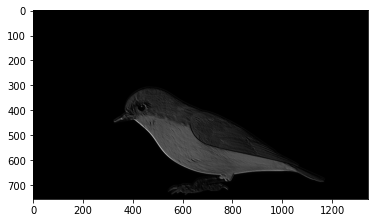

In [900]:
# predict = predict.astype(np.uint8)
plt.imshow(predict,cmap='gray') # (756,1344)
predict
# 왜 phase 모양이 꼭지점 4개로 분리되어서 나오는지 => cf fft한 값에 normalize한 과정이 있을수도? 중간에 normalize한 부분이 있는지 보자. normalize 과정을 없애니 나오긴 함. 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


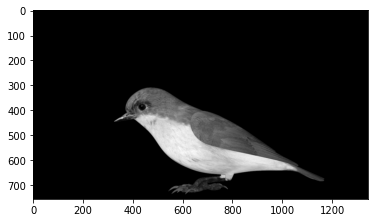

In [901]:
test_img = test_img/255. # normalize보다 255로 나누자
plt.imshow(test_img,cmap='gray')
print(test_img)

[[  8.0307166   -1.26046372 -15.29487896 ... -20.18852959 -15.29487896
   -1.26046372]
 [ 16.15216916  13.9575711   14.45028238 ...  13.02142429  15.35031712
   13.01094706]
 [  6.72039105   2.94870152   3.64955576 ...   3.69488554 -12.2588232
   -8.04059497]
 ...
 [ 15.68384293  11.21596159   4.56810505 ...  13.86245341  13.0171424
   10.55865452]
 [  6.72039105  -8.04059497 -12.2588232  ...   2.54207006   3.64955576
    2.94870152]
 [ 16.15216916  13.01094706  15.35031712 ...   5.31253165  14.45028238
   13.9575711 ]]


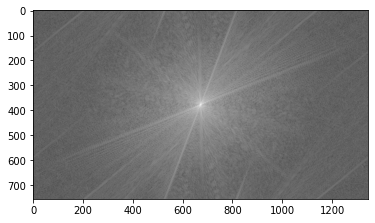

In [902]:
test_frequency = np.fft.fft2(test_img)
test_frequency1 = np.fft.fftshift(test_frequency)
# phase_frequency1 = np.abs(phase_frequency)/np.max(np.abs(phase_frequency))
magnitude_spectrum1 = 20*np.log(np.abs(test_frequency1)) # log 함수가 필요함.

plt.imshow(magnitude_spectrum1,cmap='gray')
print(magnitude_spectrum1)

In [903]:
random = np.random.random((756,1344))*2*np.pi # 2 파이를 곱해야 더 괜춘

complex_field1 = test_img*np.exp(1j*random)
complex_field2 = predict*np.exp(1j*random)

In [904]:
# frequency = np.fft.fft2(np.fft.fftshift(complex_field1))
# frequency1 = np.abs(frequency)/np.max(np.abs(frequency))
# plt.imshow(frequency1,cmap='gray')
# print(frequency1)

(756, 1344)


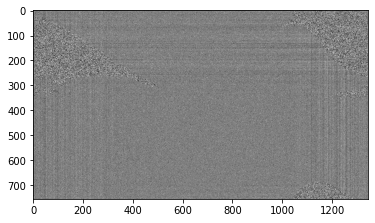

In [905]:
# sampling factor 없을 때 => cgh는 강하게 나오지만 , recon에서 스펙클이 많고 정보 손실 있음.
# sampling factor 더하기는 프린지 패턴 안 생김 (샘플링 팩터가 어떤 값이든 간에)
# sampling factor 곱하기는 프린지 패턴 생김(0.0001,0.01) # 1.5m
# 곱하기에서 0.0001 => 프린지 패턴, 0.01 => 새 모양 보임, 0.1 => 새 모양 보임, 1 => 샘플링 팩터 없을때와 같음 
# , 10 => 프린지 패턴 없음.(더하기 때와 recon이 비슷. 더하기보단 조금 더 좋음), 100 => 10과 같음, 1000 => 10,100과 같음. 

complex_holo1 = band_limited_angular_spectrum1(complex_field1,k_r,-1.5,pixel_size,wavelength_r,0.1)
phase = np.angle(complex_holo1)
phase = np.abs(phase)/np.max(np.abs(phase))
# phase = phase*np.pi
plt.imshow(phase,cmap='gray')
print(phase.shape)
# plt.imsave('./image_data/slm_phase 실험해볼 것/2D_phase_band_limited_r/Bird_f15_bl_phase.png',phase,cmap='gray')

(756, 1344)


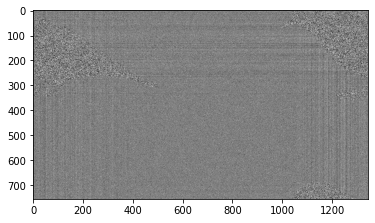

In [906]:
complex_holo_predict = band_limited_angular_spectrum1(complex_field2,k_r,-1.5,pixel_size,wavelength_r,0.1)
phase_predict = np.angle(complex_holo_predict)
phase_predict = np.abs(phase_predict)/np.max(np.abs(phase_predict))
# phase_predict = phase_predict*np.pi
plt.imshow(phase_predict,cmap='gray')
print(phase_predict.shape)
# plt.imsave('./image_data/slm_phase 실험해볼 것/2D_phase_band_limited_r/U2_11_2d_img_e20_b8_lr4d_f06_band_angular_2_Bird_f15_bl_phase.png',phase_predict,cmap='gray')

[[125.58673678  77.84240293 115.8528902  ... 132.493397   115.8528902
   77.84240293]
 [118.98109883 106.86147718 130.29307414 ... 135.70864344 103.31133705
  114.16302493]
 [104.00573666 105.54071591 108.14590459 ... 118.40355903 116.42972085
  111.03473442]
 ...
 [118.62047912 102.91428032  86.43671401 ... 125.97259037  91.11221533
  124.75237921]
 [104.00573666 111.03473442 116.42972085 ... 118.35239495 108.14590459
  105.54071591]
 [118.98109883 114.16302493 103.31133705 ... 119.63039336 130.29307414
  106.86147718]]


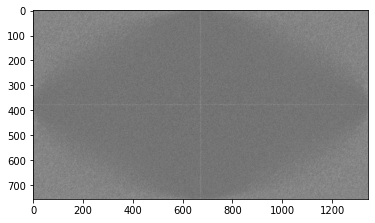

In [907]:
# 주파수 성분 확인(위상 홀로그램을 푸리에 변환하면 볼 수 있음)
# phase1 = np.exp(1j*phase)
phase_frequency = np.fft.fft2(phase)
phase_frequency = np.fft.fftshift(phase_frequency)
# phase_frequency1 = np.abs(phase_frequency)/np.max(np.abs(phase_frequency))
magnitude_spectrum = 20*np.log(np.abs(phase_frequency))

plt.imshow(magnitude_spectrum,cmap='gray')
print(magnitude_spectrum)

[[169.05864214 160.4615553  140.18187392 ... 149.00281796 140.18187392
  160.4615553 ]
 [163.68624733 148.8189274  149.49994076 ... 149.49733299 152.7541812
  154.66405355]
 [144.85316821 129.9161776  143.63343893 ... 126.07967043 148.7201616
  155.3709357 ]
 ...
 [128.7469374  150.33191999 146.57528429 ... 133.41303406 130.98545294
  126.2525145 ]
 [144.85316821 155.3709357  148.7201616  ... 118.14191412 143.63343893
  129.9161776 ]
 [163.68624733 154.66405355 152.7541812  ... 142.87308606 149.49994076
  148.8189274 ]]


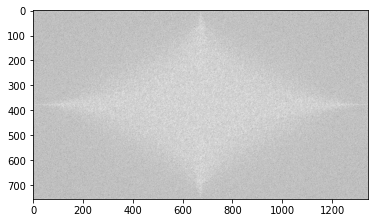

In [908]:
# 주파수 성분 확인(DPAC을 통해 만든 위상 홀로그램의 주파수는? 진폭 정보를 버리지 않은 상태)
# phase1 = np.exp(1j*phase)
DPAC_phase = double_phase_coding(complex_holo1)
phase_frequency2 = np.fft.fft2(DPAC_phase)
phase_frequency2 = np.fft.fftshift(phase_frequency2)
# phase_frequency1 = np.abs(phase_frequency)/np.max(np.abs(phase_frequency))
magnitude_spectrum2 = 20*np.log(np.abs(phase_frequency2))

plt.imshow(magnitude_spectrum2,cmap='gray')
print(magnitude_spectrum2)

(756, 1344)


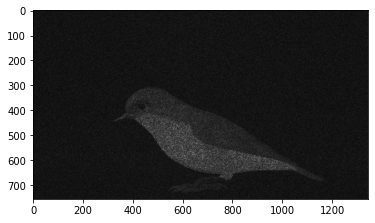

In [909]:
phase = phase - np.mean(phase)
recon = band_limited_angular_spectrum2(phase,k_r,1.5,pixel_size,wavelength_r,0.1)
plt.imshow(recon,cmap='gray')
print(recon.shape)
# plt.imsave('./image_data/Alpha/recon/bird/general_f15_Bird_multiply.png',recon,cmap='gray')

tf.Tensor(
[[0.03415263 0.0384924  0.04233344 ... 0.05537432 0.00854846 0.0219846 ]
 [0.07539616 0.05394643 0.00625377 ... 0.01872852 0.05002246 0.01849587]
 [0.07097074 0.05759631 0.0128078  ... 0.02785902 0.04901599 0.03136941]
 ...
 [0.03035867 0.04452971 0.01695327 ... 0.03555965 0.03045436 0.03501088]
 [0.0275354  0.05445438 0.06143301 ... 0.08048249 0.06332776 0.04757555]
 [0.02448496 0.06764914 0.0774284  ... 0.05985048 0.01810625 0.0182034 ]], shape=(756, 1344), dtype=float32)
(756, 1344)


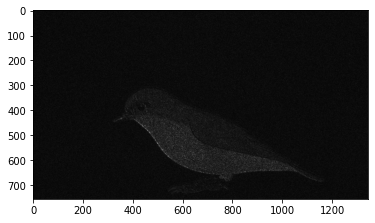

In [910]:
phase_predict = phase_predict - np.mean(phase_predict)

recon_predict = band_limited_angular_spectrum2(phase_predict,k_r,1.5,pixel_size,wavelength_r,0.1)
plt.imshow(recon_predict,cmap='gray')
print(recon_predict)
print(recon_predict.shape)
# plt.imsave('./image_data/Alpha/recon/bird/deep_general_f15_Bird_multiply.png',recon_predict,cmap='gray')

In [911]:
test_img = np.squeeze(test_img)
recon = np.squeeze(recon)
recon_predict = np.squeeze(recon_predict)

print(test_img.shape)
print(recon.shape)
print(recon_predict.shape)

(756, 1344)
(756, 1344)
(756, 1344)


In [912]:
test_img = tf.cast(test_img,tf.float32)
recon = tf.cast(recon,tf.float32)
recon_predict = tf.cast(recon_predict,tf.float32)

In [913]:
# test_img = test_img/255.

In [914]:
print(PSNR(test_img,recon),PSNR(test_img,recon_predict))

# # DPAC
# print(PSNR(test_img,recon2),PSNR(test_img,recon_predict2))


18.834210634231567 18.853851556777954


In [915]:
# 왜 갑자기 낮게 나오는지 원래꺼랑 비교해보기

test_img = np.expand_dims(test_img,axis=-1)
recon = np.expand_dims(recon,axis=-1)
recon_predict = np.expand_dims(recon_predict,axis=-1)
# recon2 = np.expand_dims(recon2,axis=-1)
# recon_predict2 = np.expand_dims(recon_predict2,axis=-1)

SSIM = tf.image.ssim(test_img,recon,max_val=1.0,filter_size=11,filter_sigma=1.5,k1=0.01,k2=0.03)
print(SSIM)

tf.Tensor(0.023264203, shape=(), dtype=float32)


In [916]:
SSIM = tf.image.ssim(test_img,recon_predict,max_val=1.0,filter_size=11,filter_sigma=1.5,k1=0.01,k2=0.03)
print(SSIM)

tf.Tensor(0.048164066, shape=(), dtype=float32)


In [917]:
# SSIM = tf.image.ssim(test_img,recon2,max_val=1.0,filter_size=11,filter_sigma=1.5,k1=0.01,k2=0.03)
# print(SSIM)

In [918]:
# SSIM = tf.image.ssim(test_img,recon_predict2,max_val=1.0,filter_size=11,filter_sigma=1.5,k1=0.01,k2=0.03)
# print(SSIM)